<a href="https://colab.research.google.com/github/AriorhBiel/Parser/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Часть 2 - анализ текстовых данных
Провести аналитику текстовых данных.

- Токенезировать и лемматизировать полученные текстовые данные полученные из 1 части задания
Токенизация - разделение слов на предложения
Лемматизация - перевод слов в начальную форму
- Посчитать наиболее встречающиеся пары подлежащих и сказуемых
- Посчитать самые популлярные слова (исключая стоп-слова, словарь стоп слов можно найти в nltk, либо отбросить по частям речи)
- Вывести статистику (по убыванию, наиболее встречающеся пары и самые популярные слова за исключением стоп-слов)

In [13]:
# Импорты
!pip install natasha
!pip install nltk
import sqlite3
import natasha
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
conn = sqlite3.connect('articles.db') # подключаемся к бд-шке
cursor = conn.cursor() # создаем курсор для операций с базой
cursor.execute('''SELECT title FROM articles LIMIT 20''') # достаем заголовки
titles = cursor.fetchall() # сохраняем их в переменную
cursor.execute('''SELECT body FROM articles LIMIT 20''') # аналогично с содержанием статей
texts = cursor.fetchall()

In [15]:
data = dict(zip(titles, texts)) # p.s. здесь открываем полученные данные

# Для примера можно использовать natasha. Импортируем нужные методы
from natasha import (
    Segmenter,
    MorphVocab,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,

    PER,
    NamesExtractor,

    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

In [5]:
from ipymarkup import show_dep_ascii_markup as show_markup
articles = list(data.values())
article = articles[19]
doc = Doc(str(article))
doc.segment(segmenter) # разбиваем текст на предложения
doc.parse_syntax(syntax_parser) # получаем представление о синтаксисе (подлежащие, сказуемое)
doc.tag_morph(morph_tagger) # получаем представление о частях речи


for sentence in doc.sents:
  sentence.syntax.print()


          ┌──► (                punct
          │ ┌► '                punct
        ┌─└─└─ Фото             
        │   ┌► :                punct
┌─┌─┌─┌─└►┌─└─ Vladimir         appos
│ │ │ │   └──► Baranov          flat:foreign
│ │ │ │     ┌► /                punct
│ │ │ └──►┌─└─ Globallookpress  flat:foreign
│ │ │     └──► .                punct
│ │ └──────►┌─ com              flat:foreign
│ │         └► \                punct
│ └──────────► n                appos
└────────────► Спрос            appos
            ┌► на               case
        ┌─┌►└─ процедуру        nmod
    ┌─┌─└►└─── обмена           nmod
    │ │     ┌► заблокированными amod
    │ └────►└─ активами         nmod
    │     ┌►┌─ со               case
    │     │ └► стороны          fixed
    └────►└─── иностранцев      nmod
            ┌► примерно         advmod
        ┌─┌─└─ равен            
        │ └►┌─ предложению      iobj
        │   └► россиян          nmod
        └────► .                punct
         

In [6]:
# Получение токенов
for sentence in doc.sents:
  for token in sentence.tokens:
    print(token)

# Заменяем слова на их леммы (начальные формы слова)
for sentence in doc.sents:
  for token in sentence.tokens:
    token.lemmatize(morph_vocab)
  lemmas = {_.text: _.lemma for _ in sentence.tokens}
  print(lemmas.items())

DocToken(stop=1, text='(', id='1_1', head_id='1_3', rel='punct', pos='PUNCT')
DocToken(start=1, stop=2, text="'", id='1_2', head_id='1_3', rel='punct', pos='PUNCT')
DocToken(start=2, stop=6, text='Фото', id='1_3', head_id='1_0', rel='root', pos='PROPN', feats=<Inan,Nom,Neut,Sing>)
DocToken(start=6, stop=7, text=':', id='1_4', head_id='1_5', rel='punct', pos='PUNCT')
DocToken(start=8, stop=16, text='Vladimir', id='1_5', head_id='1_3', rel='appos', pos='X', feats=<Yes>)
DocToken(start=17, stop=24, text='Baranov', id='1_6', head_id='1_5', rel='flat:foreign', pos='X', feats=<Yes>)
DocToken(start=25, stop=26, text='/', id='1_7', head_id='1_8', rel='punct', pos='PUNCT')
DocToken(start=27, stop=42, text='Globallookpress', id='1_8', head_id='1_5', rel='flat:foreign', pos='X', feats=<Yes>)
DocToken(start=42, stop=43, text='.', id='1_9', head_id='1_8', rel='punct', pos='PUNCT')
DocToken(start=43, stop=46, text='com', id='1_10', head_id='1_5', rel='flat:foreign', pos='X', feats=<Yes>)
DocToken(st

In [7]:
# Записываем в словарь подлежащее : сказуемое
pairs = {}
for sentence in doc.sents:
    nsubj = root = ''
    for token in sentence.tokens:
        token.lemmatize(morph_vocab)
        if token.rel in {"nsubj", "root"}:
            if token.rel == "nsubj":
                nsubj = token.lemma
            elif token.rel == "root":
                root = token.lemma
            if nsubj and root:
                pairs[nsubj] = root

all_pairs = []
for article in articles:
  doc = Doc(str(article))
  doc.segment(segmenter)
  doc.parse_syntax(syntax_parser)
  doc.tag_morph(morph_tagger)
  for sentence in doc.sents:
    nsubj = root = ''
    for token in sentence.tokens:
      token.lemmatize(morph_vocab)
      if token.rel == "nsubj":
        nsubj = token.lemma
      if token.rel == 'root':
        root = token.lemma
      if nsubj and root:
        all_pairs.append((nsubj, root))
# полученные пары не содержат пунктуации из-за отбора слов по частям речи в их начальной форме
print(all_pairs)
all_pairs_count = Counter(all_pairs)
all_pairs_count.most_common(20)

[('генерал', 'обратиться'), ('генерал', 'обратиться'), ('генерал', 'обратиться'), ('генерал', 'обратиться'), ('генерал', 'обратиться'), ('генерал', 'обратиться'), ('генерал', 'обратиться'), ('генерал', 'обратиться'), ('генерал', 'обратиться'), ('генерал', 'обратиться'), ('генерал', 'обратиться'), ('генерал', 'обратиться'), ('генерал', 'обратиться'), ('генерал', 'обратиться'), ('генерал', 'обратиться'), ('генерал', 'обратиться'), ('генерал', 'обратиться'), ('генерал', 'обратиться'), ('генерал', 'обратиться'), ('генерал', 'обратиться'), ('он', 'задаться'), ('он', 'задаться'), ('он', 'задаться'), ('он', 'задаться'), ('он', 'задаться'), ('россия', 'задаться'), ('россия', 'задаться'), ('россия', 'задаться'), ('россия', 'задаться'), ('россия', 'задаться'), ('россия', 'задаться'), ('россия', 'задаться'), ('россия', 'задаться'), ('россия', 'задаться'), ('это', 'задаться'), ('это', 'задаться'), ('это', 'задаться'), ('это', 'задаться'), ('это', 'задаться'), ('это', 'задаться'), ('это', 'задаться

[(('президент', 'стать'), 53),
 (('сотрудник', 'заявить'), 41),
 (('президент', 'предположить'), 33),
 (('это', 'пример'), 31),
 (('байден', 'непорядочный'), 31),
 (('возобновление', 'фото'), 29),
 (('строка', 'число'), 29),
 (('смартфон', 'появиться'), 29),
 (('президент', 'посетить'), 28),
 (('мужчина', 'возбудить'), 26),
 (('встреча', 'отмечаться'), 26),
 (('певец', 'разместить'), 25),
 (('суд', 'сообщаться'), 24),
 (('он', 'предположить'), 24),
 (('мужчина', 'предоставлять'), 23),
 (('россия', 'задаться'), 21),
 (('страна', 'задаться'), 21),
 (('лидер', 'приехать'), 21),
 (('нерезидент', 'стать'), 21),
 (('генерал', 'обратиться'), 20)]

In [8]:
# Наиболее частовстречающиеся слова, исключая стоп слова, знаки пунктуации и числа, а также англ. n (знак переноса строки)
import string
filtered = []
punctuation = set(string.punctuation + '«»—' + string.digits + 'n')
stop_words = set(stopwords.words('russian'))
for article in articles:
  doc = Doc(str(article))
  doc.segment(segmenter)
  doc.parse_syntax(syntax_parser)
  doc.tag_morph(morph_tagger)
  for sentence in doc.sents:
    for token in sentence.tokens:
      token.lemmatize(morph_vocab)
      if token.lemma not in punctuation and token.lemma not in stop_words:
        filtered.append(token.lemma)
# Здесь же мы конкретно используем проверку на запрещенные слова и пунктуацию
filtered_count = Counter(filtered)
filtered_count.most_common(20)

[('это', 34),
 ('россия', 27),
 ('год', 26),
 ('фото', 19),
 ('который', 16),
 ('также', 14),
 ('российский', 13),
 ('президент', 13),
 ('страна', 12),
 ('украина', 12),
 ('ранее', 11),
 ('июнь', 10),
 ('стать', 9),
 ('вопрос', 8),
 ('заявить', 8),
 ('глава', 8),
 ('путин', 8),
 ('участие', 8),
 ('свой', 7),
 ('время', 7)]

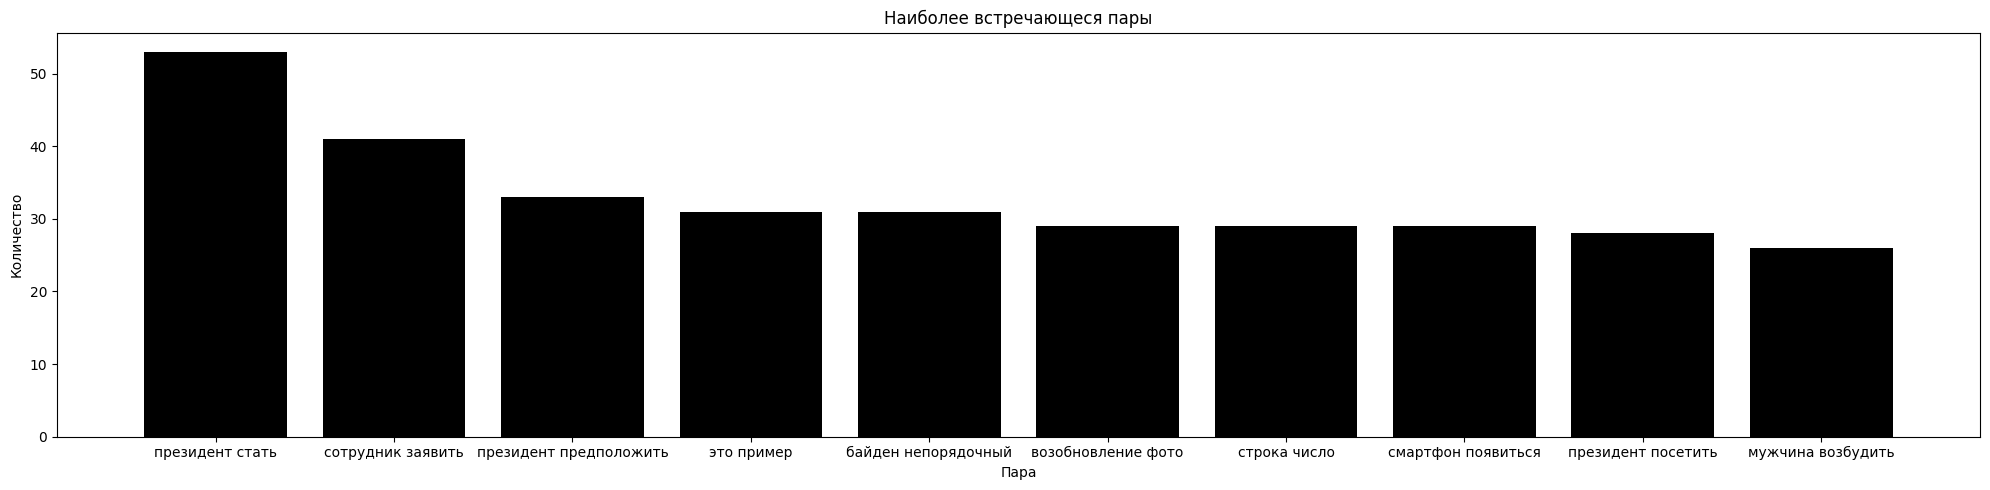

In [12]:
pairs = [pair[0][0] + ' ' + pair[0][1] for pair in all_pairs_count.most_common(10)]
count = [pair[1] for pair in all_pairs_count.most_common(10)]

plt.figure(figsize=(20, 5))
plt.bar(pairs, count, color = 'black')
plt.title("Наиболее встречающеся пары")
plt.ylabel("Количество")
plt.xlabel("Пара")
plt.tight_layout()
plt.show()

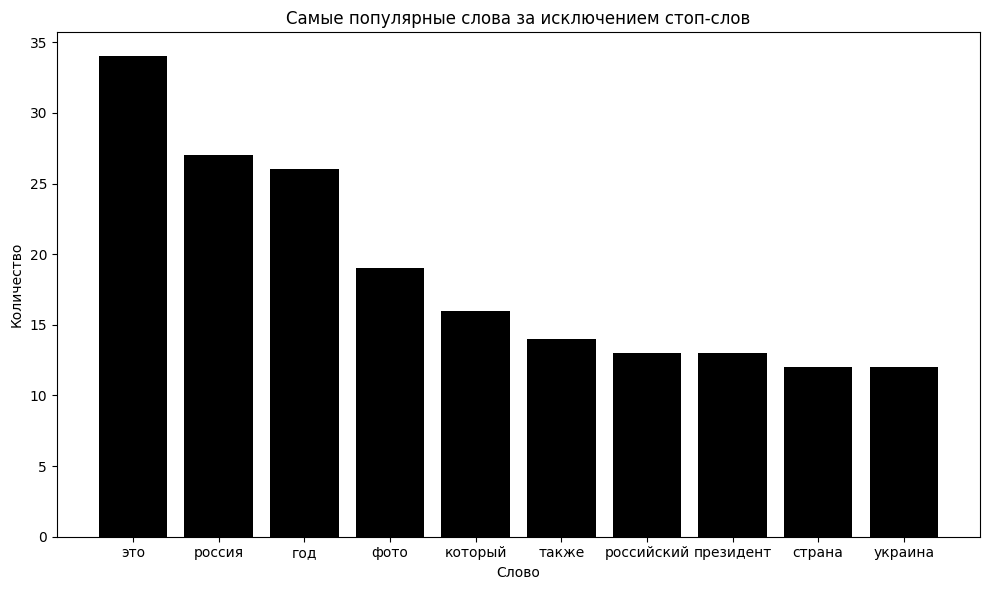

In [11]:
words = [pair[0] for pair in filtered_count.most_common(10)]
count = [pair[1] for pair in filtered_count.most_common(10)]

plt.figure(figsize=(10, 6))
plt.bar(words, count, color = 'black')
plt.title("Самые популярные слова за исключением стоп-слов")
plt.ylabel("Количество")
plt.xlabel("Слово")
plt.tight_layout()
plt.show()